In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
# Create the CSV and then create datetime column for time-series creation
df = pd.read_csv('./Data/2018Q3.csv')
# only care about minutes
df['TIME'] = pd.to_datetime(df['TIME'])
df.drop(['LAST UPDATED','NAME','STATUS','STATION ID',
         'ADDRESS','LATITUDE','LONGITUDE'], axis=1, inplace=True)
df = df.sort_values(by=['TIME'])
df.columns

Index(['TIME', 'BIKE STANDS', 'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES'], dtype='object')

In [63]:
sum_df = df.groupby('TIME').sum().reset_index()

In [64]:
mean_df = sum_df.resample('D',on='TIME').mean().round(2)
median_df = sum_df.resample('D',on='TIME').median().round(2)

In [65]:
mean_df.to_csv('mean.csv',encoding='utf-8',)
median_df.to_csv('median.csv',encoding='utf-8',)

In [14]:
# aggregating data by day 
df = df.resample('D',on='TIME').sum()
# creating the bike availability ratio to take into account total number of stands
df['AVAILABILITY RATIO'] = df['AVAILABLE BIKES'] / df['BIKE STANDS']

# negative change indicates more bikes being used and positive change indicates
# more bikes being returned
df['BIKE USAGE'] = df.groupby('STATION ID')['AVAILABILITY RATIO'].diff()


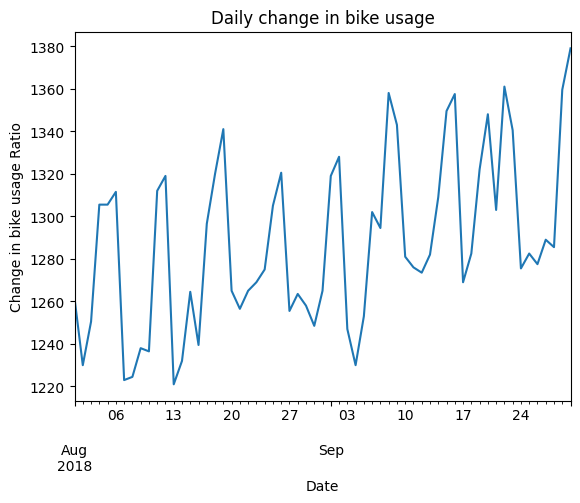

In [67]:
# visualize
median_df['AVAILABLE BIKES'].plot(kind='line')
plt.title('Daily change in bike usage')
plt.xlabel('Date')
plt.ylabel('Median of Available Bikes')
plt.show()